#### Task 2: Import Libraries and Datasets

In [119]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import string
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [120]:
# Import and read data
tweet_df = pd.read_csv("twitter.csv")

df = tweet_df.copy()

df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [121]:
# Drop ID column

df = df.drop(['id'], axis=1)

In [123]:
df.shape

(31962, 2)

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 499.5+ KB


In [125]:
df['tweet']

0         @user when a father is dysfunctional and is s...
1        @user @user thanks for #lyft credit i can't us...
2                                      bihday your majesty
3        #model   i love u take with u all the time in ...
4                   factsguide: society now    #motivation
                               ...                        
31957    ate @user isz that youuu?ðððððð...
31958      to see nina turner on the airwaves trying to...
31959    listening to sad songs on a monday morning otw...
31960    @user #sikh #temple vandalised in in #calgary,...
31961                     thank you @user for you follow  
Name: tweet, Length: 31962, dtype: object

#### Task 3: Explore Datasets

In [126]:
# Checking for Null values
df.isnull().sum()

label    0
tweet    0
dtype: int64

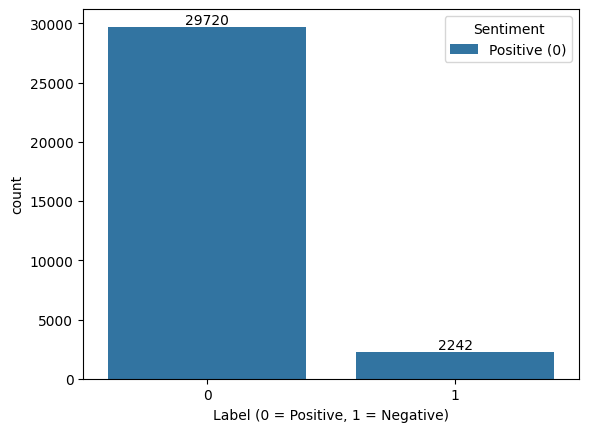

In [128]:
ax = sns.countplot(data=df, x='label')

for bars in ax.containers:
    ax.bar_label(bars)
ax.legend(title='Sentiment', labels=['Positive (0)', 'Negative (1)'])
ax.set_xlabel("Label (0 = Positive, 1 = Negative)")
plt.show()

In [129]:
# get the length of the messages

df['length'] = df['tweet'].apply(len)

In [130]:
df.head()

,label,tweet,length
0,0,@user when a father is dysfunctional and is s...,102
1,0,@user @user thanks for #lyft credit i can't us...,122
2,0,bihday your majesty,21
3,0,#model i love u take with u all the time in ...,86
4,0,factsguide: society now #motivation,39


<Axes: ylabel='Frequency'>

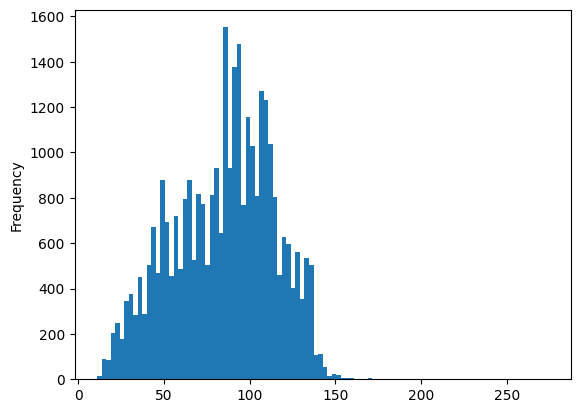

In [131]:
df['length'].plot(bins=100, kind='hist')

In [132]:
df.describe()

,label,length
count,31962.000000,31962.000000
mean,0.070146,84.739628
std,0.255397,29.455749
min,0.000000,11.000000
25%,0.000000,63.000000
50%,0.000000,88.000000
75%,0.000000,108.000000
max,1.000000,274.000000


In [133]:
# The shortest message
df[df['length'] == df['length'].min()]['tweet'].iloc[0]

'i love you '

In [134]:
# View the message with the average length
avg_length = df['length'].mean()
closest_index = (df['length'] - avg_length).abs().idxmin()
df.loc[closest_index, 'tweet']

' â\x86\x9d #under the spell of brexit referendum - commerzbank   #blog #silver #gold #forex'

df['length'].mean() – calculates average tweet length.

(df['length'] - avg_length).abs() – computes how far each tweet is from the average.

.idxmin() – finds the index of the tweet closest to the average length.

df.loc[closest_index, 'tweet'] – returns that tweet.

In [135]:
# Positive Tweets

positive = df[df['label'] == 0]

positive.head()

,label,tweet,length
0,0,@user when a father is dysfunctional and is s...,102
1,0,@user @user thanks for #lyft credit i can't us...,122
2,0,bihday your majesty,21
3,0,#model i love u take with u all the time in ...,86
4,0,factsguide: society now #motivation,39


In [136]:
# Negative Tweets

negative = df[df['label'] == 1]

negative.head()

,label,tweet,length
13,1,@user #cnn calls #michigan middle school 'buil...,74
14,1,no comment! in #australia #opkillingbay #se...,101
17,1,retweet if you agree!,22
23,1,@user @user lumpy says i am a . prove it lumpy.,47
34,1,it's unbelievable that in the 21st century we'...,104


In [137]:
len(positive)

29720

In [138]:
len(negative)

2242

#### Task 4: Plot the WordCloud

In [142]:
sentences = df['tweet'].tolist()  # converts the Series into a Python list.

In [143]:
len(sentences)

31962

In [144]:
sentences_as_one_string = " ".join(sentences)

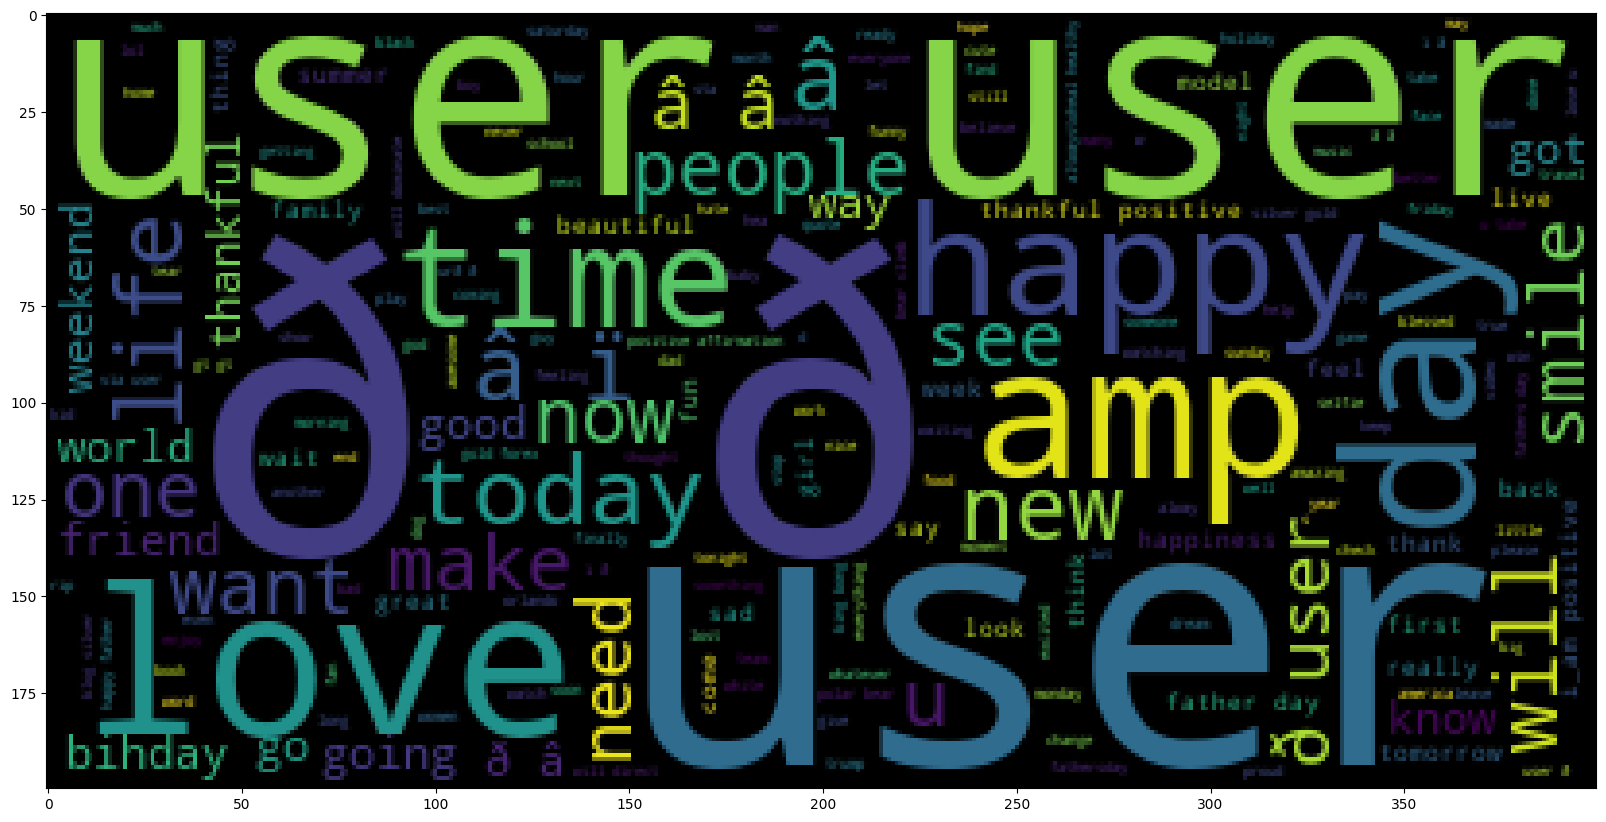

In [145]:
from wordcloud import WordCloud

plt.figure(figsize=(20, 20))
plt.imshow(WordCloud().generate(sentences_as_one_string))

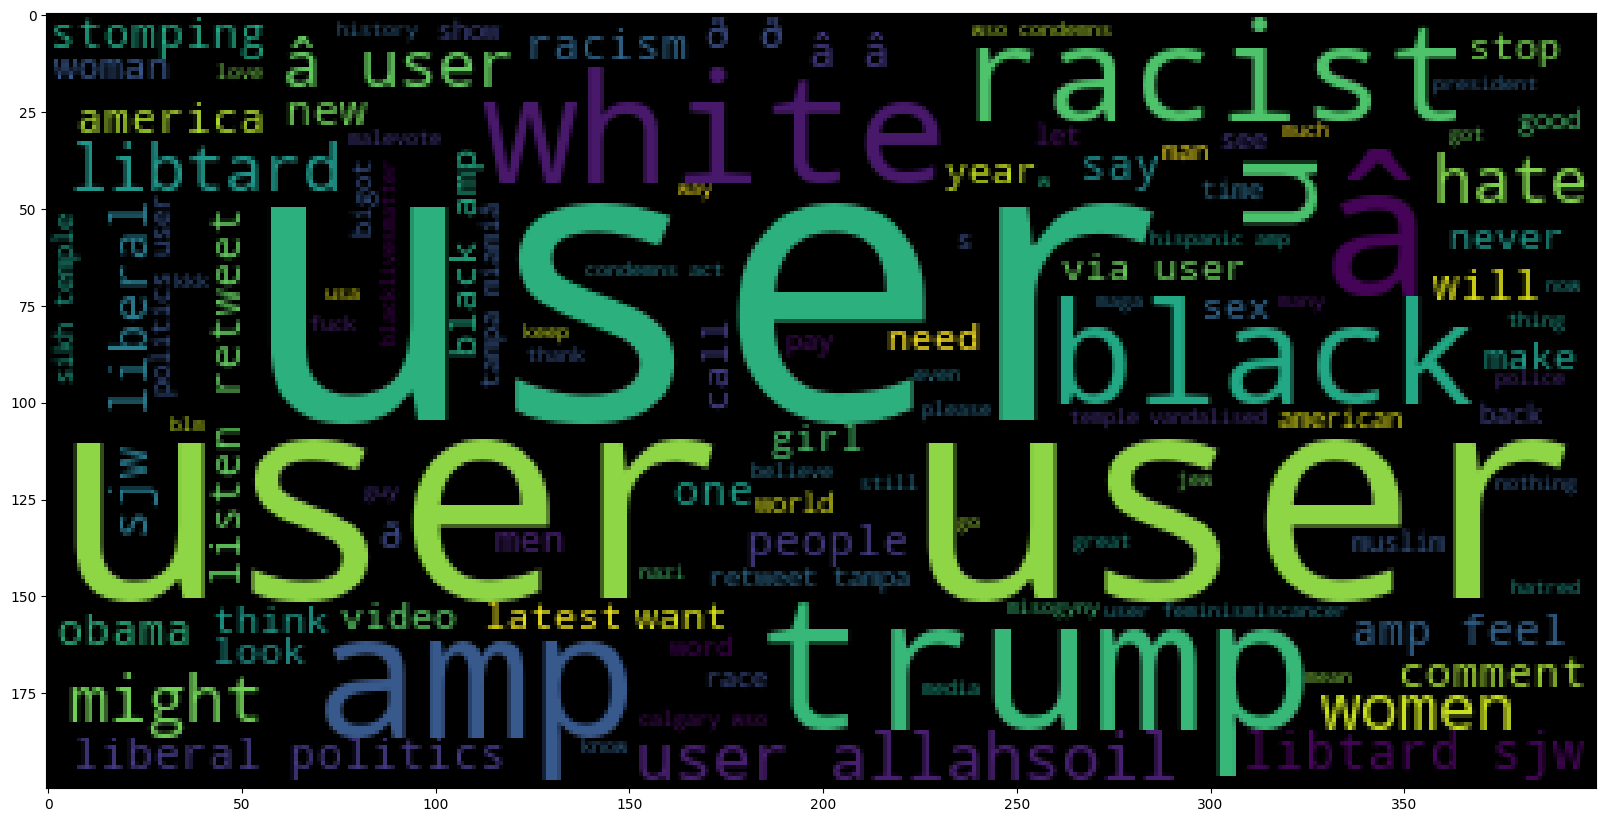

In [146]:
# Plot the WordCloud for "negative" dataframe

negative_list = negative['tweet'].tolist()
negative_sentences_as_one_string = " ".join(negative_list)
plt.figure(figsize=(20, 20))
plt.imshow(WordCloud().generate(negative_sentences_as_one_string))

#### Task 5: Remove Punctuation, Stop Words, and perform count vectorization

In [148]:
# Download stopwords
nltk.download('stopwords')

# Combine NLTK and sklearn stopwords
stop_words = set(stopwords.words('english')).union(text.ENGLISH_STOP_WORDS)

# Text cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www.\S+", "", text)                  # Remove URLs
    text = re.sub(r"@\w+", "", text)                             # Remove mentions (@usernames)
    text = re.sub(r"\d+", "", text)                              # Remove numbers
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)                   # Remove non-ASCII characters
    text = re.sub(rf"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)                   # Reduce repeating characters
    text = re.sub(r'\s+', ' ', text).strip()                     # Remove extra spaces
    words = text.split()
    filtered = [word for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(filtered)

# Apply cleaning
tweet_df['tweet'] = tweet_df['tweet'].fillna('').astype(str)
tweet_df['tweet'] = tweet_df['tweet'].apply(clean_text)

# Remove empty tweets
tweet_df = tweet_df[tweet_df['tweet'].str.strip() != '']

# Vectorize cleaned tweets
vectorizer = CountVectorizer(
    stop_words='english',
    token_pattern=r'\b[a-z]{3,}\b',  # Lowercase words, min 3 letters
    min_df=5                         # Ignore rare words (appear in <5 tweets)
)

X = vectorizer.fit_transform(df['tweet'])

# Vocabulary and word frequencies
vocab = vectorizer.get_feature_names_out()
word_counts = X.toarray().sum(axis=0)
word_freq = dict(zip(vocab, word_counts))

# Display top 20 words
top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]
print("Top 20 words by frequency:")
for word, freq in top_words:
    print(f"{word}: {freq}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kshit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 20 words by frequency:
user: 17577
love: 2749
day: 2311
amp: 1776
happy: 1686
just: 1365
time: 1136
life: 1131
today: 1079
like: 1050
new: 997
thankful: 946
positive: 931
people: 874
good: 867
bihday: 845
smile: 712
don: 665
want: 649
father: 635


In [149]:
print(vectorizer.get_feature_names_out()[:20])

['aap' 'abandoned' 'abc' 'ability' 'able' 'abrahamhicks' 'absolute'
 'absolutely' 'abt' 'abundance' 'abuse' 'academy' 'acc' 'accent' 'accept'
 'acceptable' 'acceptance' 'accepted' 'accepting' 'access']


In [150]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### Task 6: Create Pipeline to remove punctuations, stopwords and perform count vectorization

In [151]:
# cleaning function
def message_cleaning(message):
    # Remove punctuation
    Test_punc_removed = [char for char in message if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)
    
    # Remove stopwords
    Test_punc_removed_join_clean = [
        word for word in Test_punc_removed_join.split()
        if word.lower() not in stop_words
    ]
    
    return Test_punc_removed_join_clean

In [152]:
tweets_df_clean = tweet_df['tweet'].apply(message_cleaning)

In [153]:
print(tweets_df_clean[5])

['huge', 'fan', 'fare', 'big', 'talking', 'leave', 'chaos', 'pay', 'disputes', 'allshowandnogo']


In [154]:
print(tweet_df['tweet'][5])

huge fan fare big talking leave chaos pay disputes allshowandnogo


In [155]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer=message_cleaning)
tweets_countvectorizer = CountVectorizer(analyzer=message_cleaning, dtype='uint8').fit_transform(tweet_df['tweet']).toarray()

In [156]:
tweets_countvectorizer.shape

(31891, 38686)

In [157]:
X = tweets_countvectorizer

y = tweet_df['label']

#### Task 7: Train a Naive Bayes Classification Model

In [158]:
X.shape

(31891, 38686)

In [159]:
y.shape

(31891,)

In [160]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [161]:
from sklearn.naive_bayes import MultinomialNB

NB_Classifier = MultinomialNB()
NB_Classifier.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


#### Task 8: Assess Train Model Performance

<Axes: >

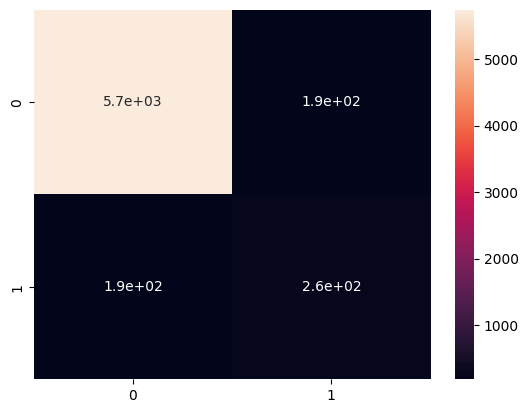

In [162]:
from sklearn.metrics import classification_report, confusion_matrix

y_predict_test = NB_Classifier.predict(X_test)
cm =  confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True)

In [163]:
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5931
           1       0.58      0.58      0.58       448

    accuracy                           0.94      6379
   macro avg       0.77      0.78      0.78      6379
weighted avg       0.94      0.94      0.94      6379

